In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import tensorflow as tf
import os, sys, time
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import utils, optimization, metrics, plot
import pickle


# Parameters

In [3]:
spix = 256
path = '/home/nati/data/andresro/dat/size{}_splits1000_n500x3/'.format(spix)
input_pattern = 'Box_70*snapshot_050'
file_ext = '.dat'
k = 10

# Data handling

Load the data

In [4]:
queue = []
for file in os.listdir(path):
    if file.endswith(file_ext) and (np.all([x in file for x in input_pattern.split("*")])):
        queue.append(os.path.join(path, file))
nsamples = len(queue)
print('They are {} "{}" files.'.format(nsamples, file_ext))      

They are 15000 ".dat" files.


In [5]:
input_img = np.vstack(map(lambda i:np.fromfile(queue[i], dtype=float32), range(nsamples)))
input_img.resize([nsamples,spix,spix])

In [6]:
input_img = utils.forward_map(input_img,k)

# input_img = np.log(input_img+0.001)

# p = np.random.permutation(nsamples)
# input_img = input_img[p,]

Let us plot 16 images

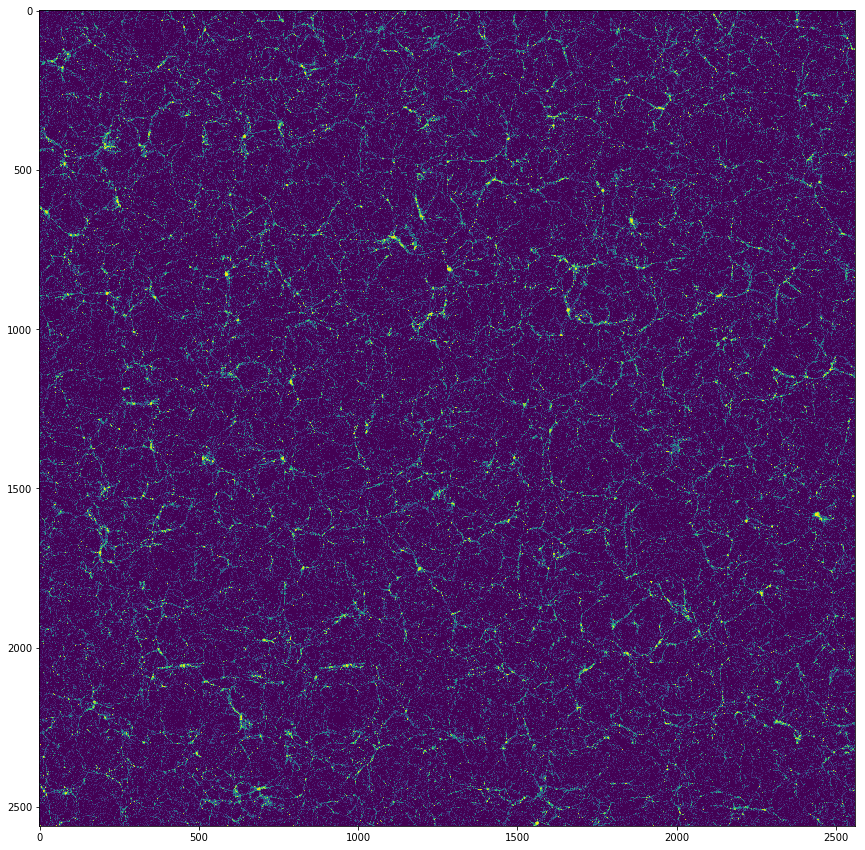

In [7]:
plt.figure(figsize=(15,15))
utils.draw_images(input_img,nx=10,ny=10,px=spix,py=spix)

This one looks strange (only for the 512x512)

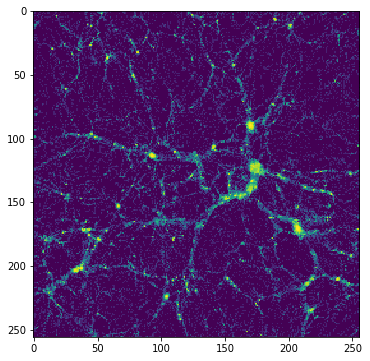

In [8]:
plt.figure(figsize=(6,6))
plt.imshow(input_img[8,:,:])

It is a band of zeros...

array([[ 0.,  0.,  0., ...,  1.,  0.,  0.],
       [ 0.,  0.,  1., ...,  4.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  0.,  2.],
       ..., 
       [ 2.,  0.,  1., ...,  2.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 1.,  0.,  0., ...,  0.,  1.,  1.]], dtype=float32)

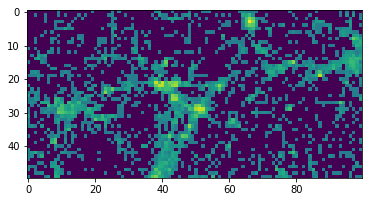

In [9]:
ori = np.fromfile(queue[8], dtype=float32).reshape([spix,spix])
plt.imshow(np.log(ori[150:200,:100]+0.01))
ori[150:200,:100]

Let us make small patches of 64 :-)

In [10]:
nx = 128
ny = 64
cutx = spix//nx
cuty = spix//ny
img_small = np.zeros([nsamples*cutx*cuty, nx, ny])
for i in range(cutx):
    for j in range(cuty):
        k = j + i*cuty 
        img_small[k*nsamples:(k+1)*nsamples,:,:] = input_img[:,i*nx:(i+1)*nx,j*ny:(j+1)*ny]


# # Reduce the size
# ns = 64
# cut = spix//ns
# img_small = input_img[:,:ns,:ns].copy()
# del input_img

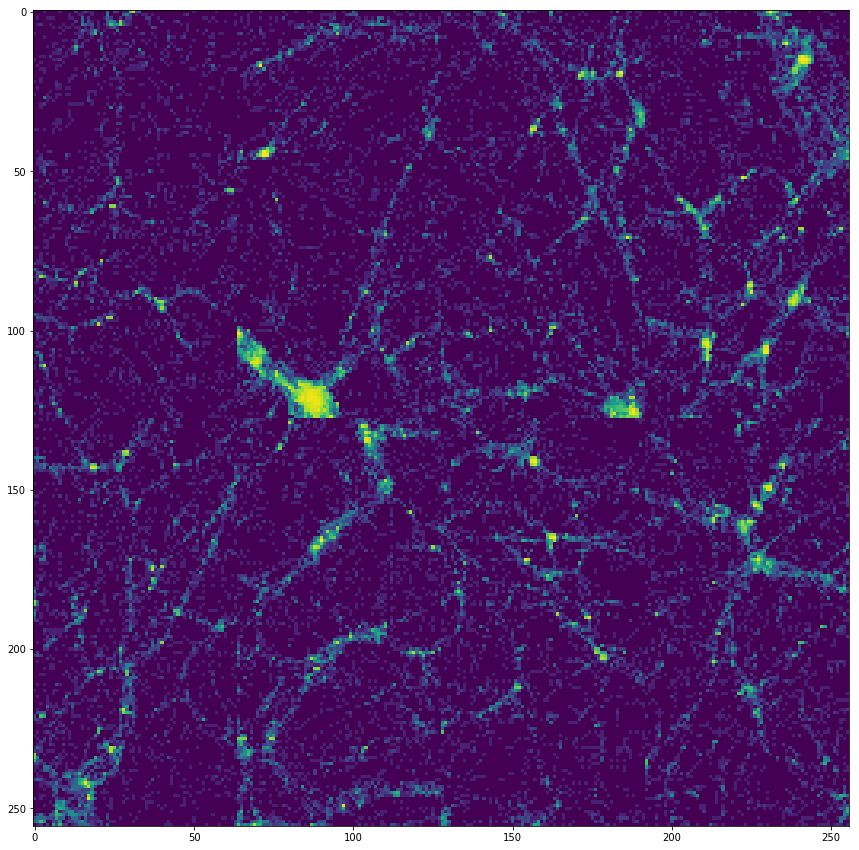

In [11]:
plt.figure(figsize=(15,15))
utils.draw_images(img_small,nx=2,ny=4,px=nx,py=ny)

# PSD stuff

In [12]:
raw_img = np.vstack(map(lambda i:np.fromfile(queue[i], dtype=float32), range(1000)))
raw_img.resize([nsamples,spix,spix])

/home/nati/.virtualenvs/py3-gpu/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/nati/.virtualenvs/py3-gpu/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/nati/.virtualenvs/py3-gpu/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


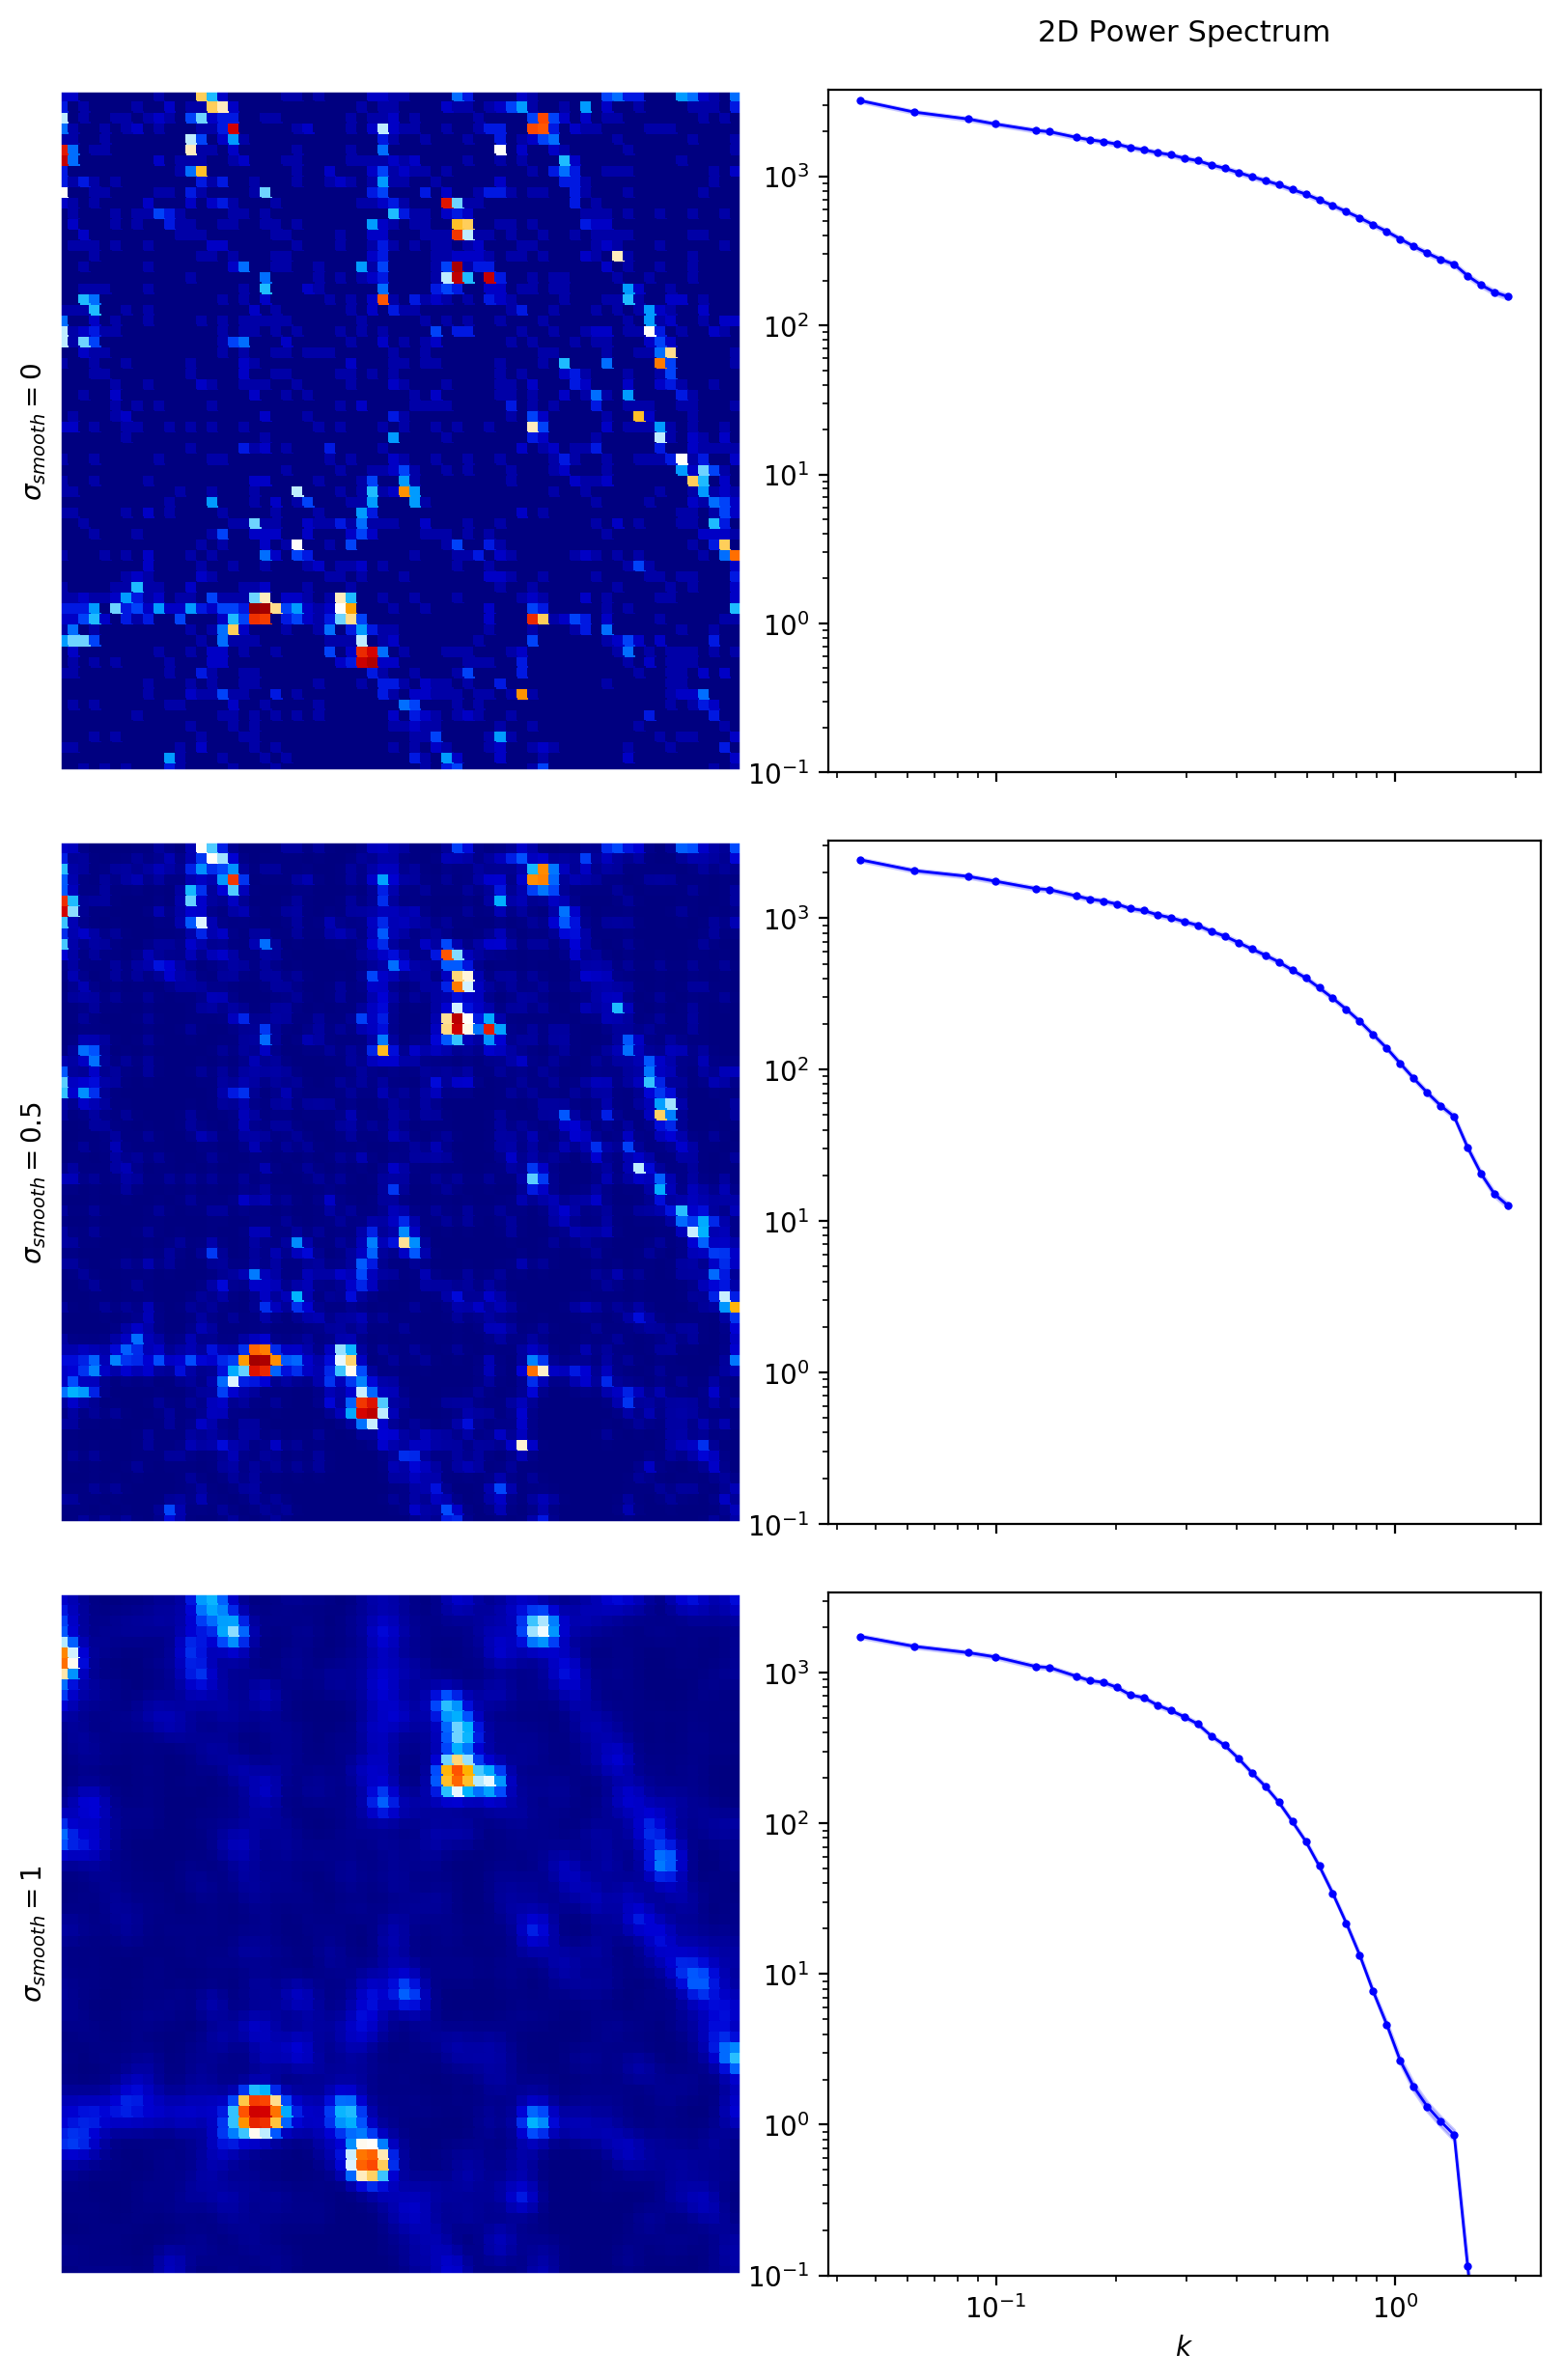

In [13]:

plot.plot_images_psd(raw_img[:1000,:nx,:ny],'' , sigma_smooth = [0,0.5,1])


# A) Train a small GAN

In [17]:
def current_time_str():
    import time, datetime
    d = datetime.datetime.fromtimestamp(time.time())
    return str(d.year)+ '_' + str(d.month)+ '_' + str(d.day)+ '_' + str(d.hour)+ '_' + str(d.minute)



params_discriminator = dict()
params_discriminator['stride'] = [2, 2, 2, 2]
params_discriminator['nfilter'] = [16, 32, 64, 128]
params_discriminator['shape'] = [[5, 5],[5, 5], [5, 5], [3, 3]]
params_discriminator['batch_norm'] = [True, True, True, True]
params_discriminator['full'] = []
params_discriminator['summary'] = True

params_border = dict()
params_border['width_full'] = 8
params_border['stride'] = [4, 2]
params_border['nfilter'] = [10, 1]
params_border['shape'] = [[7, 7],[5, 5]]
params_border['batch_norm'] = [True, True]
params_border['axis'] = 1

params_generator = dict()
params_generator['stride'] = [2, 2, 2, 1]
params_generator['latent_dim'] = 100
params_generator['nfilter'] = [128, 64, 32, 1]
params_generator['shape'] = [[3, 3],[3, 3], [5, 5], [5, 5]]
params_generator['batch_norm'] = [True, True, True]
params_generator['full'] = [8*8*128]
params_generator['summary'] = True
params_generator['non_lin'] = 'tanh'
params_generator['border'] = params_border

params_optimization = dict()
params_optimization['gamma_gp'] = 0.1
params_optimization['batch_size'] = 32
params_optimization['optimizer'] = 'adam' # rmsprop / adam
params_optimization['disc_learning_rate'] = 1e-4
params_optimization['gen_learning_rate'] = 1e-4
params_optimization['beta1'] = 0.99
params_optimization['beta2'] = 0.999
params_optimization['epsilon'] = 1e-8
params_optimization['epoch'] = 100



params = dict()
params['generator'] = params_generator
params['discriminator'] = params_discriminator
params['optimization'] = params_optimization

params['image_size'] = [nx, ny]
params['sum_every'] = 200
params['viz_every'] = 200
params['save_every'] = 2000
global_path = '/home/nati/data/GAN/'+ current_time_str() +'12_{}/'.format(nx)
params['summary_dir'] = global_path + 'summary'
params['save_dir'] = global_path + 'checkpoints'

params['clip_max_real'] = False
params['log_clip'] = 0.1
params['sigma_smooth'] = 1
params['simple_constant'] = k
params['k'] = k


In [18]:
from model import generator12, discriminator
from gan import WGAN

class gan12_model(object):
    def __init__(self, name='wgan12'):
        self.name = name
    def generator(self, z, X, reuse):
        return generator12(z, X, self.params['generator'], reuse=reuse)
    def discriminator(self, X, reuse):
        return discriminator(X, self.params['discriminator'], reuse=reuse)
    def __call__(self, params, z, X):
        self.params = params
        X1, X2 = tf.split(X, 2, axis = params['generator']['border']['axis'])
        G_fake = self.generator(z, X1, reuse=False)
        D_real = self.discriminator(X, reuse=False)
        D_fake = self.discriminator(G_fake, reuse=True)       
    
        return G_fake, D_real, D_fake

wgan12_model = gan12_model()
wgan_obj = WGAN(params, wgan12_model)



Border block 
------------------------------------------------------------
     BORDER:  The input is of size (?, 64, 64, 1)
     BORDER: 0 Conv layer with 10 channels
         Batch norm
         BORDER:  Size of the conv variables: (?, 16, 16, 10)
     BORDER: 1 Conv layer with 1 channels
         Batch norm
         BORDER:  Size of the conv variables: (?, 8, 8, 1)
     BORDER:  Size of the border variables: (?, 512)
     BORDER:  Size of the conv variables: (?, 64)
     Latent:  Size of the Z variables: (?, 100)
------------------------------------------------------------

Generator 
------------------------------------------------------------
     The input is of size (?, 676)
     0 Full layer with 8192 outputs
         Size of the variables: (?, 8192)
     Reshape to (?, 8, 8, 128)
     1 Deconv layer with 128 channels
         Batch norm
         Size of the variables: (?, 16, 16, 128)
     2 Deconv layer with 64 channels
         Batch norm
         Size of the variables: (?, 

In [19]:
wgan_obj.train(img_small)

Epoch: [ 0] [  99/3750] Counter:100	( 0.5 min	99.95 examples/sec	0.320 sec/batch)	L_Disc:0.00046861	L_Gen:-0.99999708
Epoch: [ 0] [ 199/3750] Counter:200	( 1.0 min	112.90 examples/sec	0.283 sec/batch)	L_Disc:0.00051774	L_Gen:-0.99999976


/home/nati/.virtualenvs/py3-gpu/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/nati/.virtualenvs/py3-gpu/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


 [*] [Fake, Real] Min [3.150, 0.136],	Median [41.685,0.574],	Mean [1.146E+02,1.373E+00],	 Max [7.861E+03,8.919E+01],	 Var [2.059E+05,2.361E+01]
 [*] [Comp, Fake, Real] PeakDistance:[2.480, 2.962, 0.130]	CrossPS:[2.721, -3.272, -1.519]	PSD_Diff:979.709
 [*] New PSD Low achieved 979.709096 (was 10000000000.000000)
Epoch: [ 0] [ 299/3750] Counter:300	( 1.8 min	63.55 examples/sec	0.504 sec/batch)	L_Disc:0.00146003	L_Gen:-0.99999505
Epoch: [ 0] [ 399/3750] Counter:400	( 2.3 min	112.56 examples/sec	0.284 sec/batch)	L_Disc:0.00741212	L_Gen:-0.99999857
 [*] [Fake, Real] Min [2.850, 0.138],	Median [32.064,0.566],	Mean [8.215E+01,1.476E+00],	 Max [5.742E+03,1.253E+02],	 Var [1.023E+05,4.546E+01]
 [*] [Comp, Fake, Real] PeakDistance:[1.886, 2.210, 0.207]	CrossPS:[1.769, -10.264, 7.246]	PSD_Diff:6008.044
Epoch: [ 0] [ 499/3750] Counter:500	( 3.1 min	67.07 examples/sec	0.477 sec/batch)	L_Disc:0.00020451	L_Gen:-0.99999595
Epoch: [ 0] [ 599/3750] Counter:600	( 3.6 min	112.14 examples/sec	0.285 sec/ba

KeyboardInterrupt: 